In [499]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import pycountry
import pypopulation
from geojson import FeatureCollection, dump
import numpy as np
import xlrd
import matplotlib.pyplot as plt

## Geocoding
Assigning countries coordinates

In [500]:
load_dotenv()
TOKEN=os.getenv("MAPBOX_TOKEN")
df = pd.read_csv("../output/processed/flows.csv") # ../output/processed/
origins = list(df.origin.unique())
destinations = list(df.destination.unique())

In [501]:
in_first = set(origins)
in_second = set(destinations)
in_second_but_not_in_first = in_second - in_first
countries = origins + list(in_second_but_not_in_first)

In [502]:
df = pd.DataFrame({"country":countries})

In [503]:
headers = {'Accept': 'application/json'}
lst = []
for i in countries:
    obj = {}
    obj["type"]="Feature"
    obj["properties"]={"name": pycountry.countries.get(alpha_2=i).name}
    pop = pypopulation.get_population_a2(i)
    url = f"https://api.mapbox.com/geocoding/v5/mapbox.places/{i}.json?&types=country&access_token={TOKEN}"
    r = requests.get(url)
    jason = r.json()
    obj["properties"]["code"] = i.lower()
    coords = jason["features"][0]["center"]
    obj["geometry"] = {"type":"Point", "coordinates": coords}
    lst.append(obj)
    df.loc[df["country"] == i, "lat"] = coords[1]
    df.loc[df["country"] == i, "lon"] = coords[0]
    df.loc[df["country"] == i, "name"] = obj["properties"]["name"]
    df.loc[df["country"] == i, "population"] = pop

In [504]:
with open('../output/processed/countries.geojson', 'w') as f:
    dump(FeatureCollection(lst), f)

In [505]:
df['population'] = df['population'].fillna(0).astype(int)

In [506]:
# filling one country manually
df.loc[df[df["name"]=="Saint Barthélemy"].index, 'population'] = 10457
df = df.astype({'population':'str'})

## Clustering


In [507]:
# https://unstats.un.org/unsd/methodology/m49/overview/
regions = pd.read_excel("regions.xls")

In [508]:
def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = int(regions[regions["ISO-alpha3 Code"] == iso3]["Sub-region Code"].values[0])
    return result

df["sub_region_code"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3]["Sub-region Name"].values[0]
    return result

df["sub_region_name"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = int(regions[regions["ISO-alpha3 Code"] == iso3]["Region Code"].values[0])
    return result

df["region_code"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3]["Region Name"].values[0]
    return result

df["region_name"] = df.apply(lambda x: func(x["country"]), axis=1)



In [509]:
df

,country,lat,lon,name,population,sub_region_code,sub_region_name,region_code,region_name
0,ad,42.548654,1.576766,Andorra,77142,39,Southern Europe,150,Europe
1,ae,1.612130,10.525771,United Arab Emirates,9770529,145,Western Asia,142,Asia
2,af,33.838806,66.026471,Afghanistan,38041754,34,Southern Asia,142,Asia
3,al,28.163240,2.632388,Albania,2854191,39,Southern Europe,150,Europe
4,am,39.381266,-97.922211,Armenia,2957731,145,Western Asia,142,Asia
...,...,...,...,...,...,...,...,...,...
150,as,-14.304405,-170.707833,American Samoa,55312,61,Polynesia,9,Oceania
151,gi,10.785546,-11.029862,Gibraltar,33701,39,Southern Europe,150,Europe
152,in,22.199166,78.476681,India,1366417754,34,Southern Asia,142,Asia
153,us,39.381266,-97.922211,United States,328239523,21,Northern America,19,Americas


In [510]:
def centroids(typ):
    obj = {}
    for i in list(df[f"{typ}_name"].unique()):
        lats = df[df[f"{typ}_name"] == i]["lat"]
        lons = df[df[f"{typ}_name"] == i]["lon"]
        lat = sum(lats)/len(lats)
        lon = sum(lons)/len(lons)
        obj[i] = [lat,lon]

    df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]][0], axis=1)
    df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]][1], axis=1)

df["region2_name"] = df["region_name"]
df.loc[df["name"].isin(["Samoa","American Samoa"]), "region2_name"] = 0

In [511]:
centroids("region2")
centroids("sub_region")
df.drop('region2_name', axis = 1, inplace=True)
df.rename(columns={'region2_lat': "region_lat", "region2_lon": "region_lon" }, inplace=True)

In [512]:
df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lat"] = df.loc[df["name"] == "Australia"]["region_lat"].values[0]
df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lon"] = df.loc[df["name"] == "Australia"]["region_lon"].values[0]

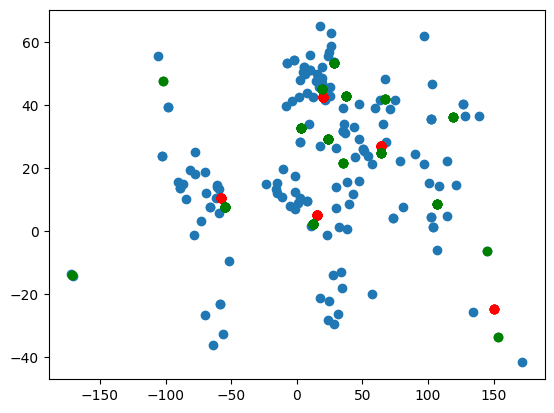

In [513]:
plt.scatter(df["lon"], df["lat"])
plt.scatter(df["region_lon"], df["region_lat"], c="red")
plt.scatter(df["sub_region_lon"], df["sub_region_lat"], c="green")
plt.show()

In [514]:
df.rename(columns={"country": "code"}, inplace=True)
df.drop("region2_name", axis=1, inplace=True)

KeyError: "['region2_name'] not found in axis"

In [515]:
df = df[["code","name","lat","lon","region_code","region_name","region_lat","region_lon","sub_region_code","sub_region_name", "sub_region_lat", "sub_region_lon","population"]]
df

,code,name,lat,lon,region_code,region_name,region_lat,region_lon,sub_region_code,sub_region_name,sub_region_lat,sub_region_lon,population
0,ad,Andorra,42.548654,1.576766,150,Europe,42.467194,20.181702,39,Southern Europe,32.614556,2.915928,77142
1,ae,United Arab Emirates,1.612130,10.525771,142,Asia,27.076799,64.186966,145,Western Asia,29.059314,24.044483,9770529
2,af,Afghanistan,33.838806,66.026471,142,Asia,27.076799,64.186966,34,Southern Asia,24.809203,64.107784,38041754
3,al,Albania,28.163240,2.632388,150,Europe,42.467194,20.181702,39,Southern Europe,32.614556,2.915928,2854191
4,am,Armenia,39.381266,-97.922211,142,Asia,27.076799,64.186966,145,Western Asia,29.059314,24.044483,2957731
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,as,American Samoa,-14.304405,-170.707833,9,Oceania,-24.684074,150.503737,61,Polynesia,-14.071868,-171.235791,55312
151,gi,Gibraltar,10.785546,-11.029862,150,Europe,42.467194,20.181702,39,Southern Europe,32.614556,2.915928,33701
152,in,India,22.199166,78.476681,142,Asia,27.076799,64.186966,34,Southern Asia,24.809203,64.107784,1366417754
153,us,United States,39.381266,-97.922211,19,Americas,10.294977,-57.708206,21,Northern America,47.483584,-101.836404,328239523


In [516]:
df.to_csv("../output/processed/countries.csv", index=False)